In [49]:
#  import package and data, set wd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pandas as pd
from scipy.optimize import curve_fit


In [50]:
#  set parameters

#  work path
wd_ = 'C:/Users/daizh/sheared_granular_gouge/20231116_FifthRun3/PythonFile_CalculateGranularQuantity'

# define the average d of balls
d_average_ = 2.5e-5

#%% define file to be plotted
list_filename_ = ['correlation_data/correlation_of_nonaffine_from_0_to_40.npy',
                 'correlation_data/correlation_of_nonaffine_from_60_to_100.npy',
                 'correlation_data/correlation_of_nonaffine_from_100_to_140.npy',
                 'correlation_data/correlation_of_nonaffine_from_820_to_860.npy']
colors_ = ['g', 'y', 'r', 'b']
if len(list_filename_) != len(colors_):
    print('The program terminated!!!\nThe size of \'list_filename_\' and \'colors_\' is not the same')
    sys.exit()
labels_ = ['I. linear, $\\xi$ = %.2f d$_\\mathrm{avg}$',
          'II. yield, $\\xi$ = %.2f d$_\\mathrm{avg}$',
          'III. unstable shearing, $\\xi$ = %.2f d$_\\mathrm{avg}$',
          'IV. stable shearing, $\\xi$ = %.2f d$_\\mathrm{avg}$']
if len(list_filename_) != len(labels_):
    print('The program terminated!!!\nThe size of \'list_filename_\' and \'colors_\' is not the same')
    sys.exit()   
# correlation length
correlation_length_ = [] # record the correlation length here


#%% define index to be calculated
index_former_ = [0, 60, 100, 820]
index_later_ = [40, 100, 140, 860]
if len(index_former_) != len(index_later_):
    print('The program terminated!!!\nThe size of \'index_former\' and \'index_later\' is not the same')
    sys.exit()
    
# set the mesh grid
precision_ = 100
x_lol_ = 0.5e-3 # lower limit of x
x_upl_ = 3.5e-3 # upper limit of x
y_lol_ = 1e-3 # lower limit of y
y_upl_ = 3e-3 # upper limit of y
xx_ = np.linspace(x_lol_,x_upl_, num = 2 * precision_)
yy_ = np.linspace(y_lol_,y_upl_, num = precision_)
grid_xx_, grid_yy_ = np.meshgrid(xx_, yy_)

# set the translate threshold
thresh_trans_ = 0


# set the filter extrem threshold
thresh_ = float('Inf')

# set the plot parameter
# the fit function
def func(x, a):
    return np.exp(a*x)

In [51]:
# change wd and import functions
#%% change current directory
os.chdir(wd_)
# import functions
from import_data import *

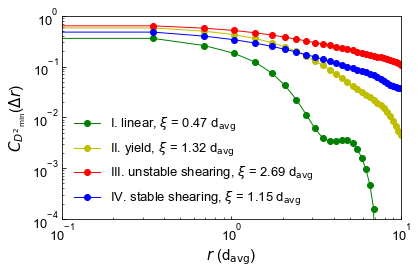

In [52]:
steps_ = len(list_filename_)
for i_ in range(steps_):
#     import data
    correlation_ = np.load(list_filename_[i_])
    # correlation_: row 0, i.e. correlation_[0, :] is the prescribed mutual distance
    # correlation_: row 1, i.e. correlation_[1, :] is the prescribed mutual distance
    #     fit and plot
    popt, pcov = curve_fit(func, correlation_[0, :] / d_average_, correlation_[1, :])
    rr_ = np.linspace(correlation_[0, :][0]/ d_average_,correlation_[0, :][-1]/ d_average_, num = 100)
#     plt.plot(rr_, func(rr_, popt),  linewidth = 1, color = colors_[i_])
    correlation_length_.append(-1/popt[0])
    
#     plot
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['font.size'] = 13
    plt.rc('font', family = 'Arial')

    plt.plot(correlation_[0, :] / d_average_, correlation_[1, :],  linewidth = 1, color = colors_[i_], marker = 'o',
            label =  labels_[i_] % (-1 / popt[0]))

    plt.ylim(10**-4,10**0)
    plt.xlim(10**-1,10**1)
#     plt.axhline(0, linestyle = '--', color = 'r', linewidth = 1)
    plt.xlabel('$\\mathit{r}$ (d$_\\mathrm{avg}$)', fontsize = 15)
    plt.ylabel('$\\mathit{C}$' + '$_\\mathit{D}$'+ '$_{^\\mathrm{2}}$' + '$_{_\\mathrm{min}}$($\\Delta\\mathit{r}$)', fontsize = 15)
    


    
    plt.xscale('log')
    plt.yscale('log')
#     plt.title('Small slip, time = %.2fms ' % ConSV_PlateBottomBeadMiddle_.loc[i_ + index1_,'Time'])
    plt.tight_layout()
#     plt.savefig('note_book_plot/correlation_of_%s.svg' % os.path.splitext(os.path.basename(list_filename_[i_]))[0], dpi=600, format='svg')
#     plt.show()
plt.legend()
plt.legend(frameon = False)
plt.savefig('note_book_plot/correlation_in_four_stage.svg', dpi=600, format='svg')

In [53]:
#%% Screen particles according to x to avoid effects caused by BC
def screen_grains_by_x(l_lim_, u_lim_, c_, v_):
    '''
    l_lim_ - lower limit
    u_lim_ - upper limit
    c_ - c coodinate
    v_ - corresponding variables
    
    returns:
        cnew_ - the  coodinate in a centain range
        vnew_ - the correspnding coodinate in a certain range
    
    '''
    cnew_, vnew_ = [], [] # initialize
    for i_ in range(c_.shape[0]):
        
        if c_[i_][0] > l_lim_ and c_[i_][0]  < u_lim_:
            cnew_.append(c_[i_][:])
            vnew_.append(v_[i_])

    return np.array(cnew_), np.array(vnew_)  # return handled coodinate and variables.

# cnew_, ynew_ = screen_grains_by_x(0.5, 3.5, x_, y_)
# cnew_, vnew_ = screen_grains_by_x(0.5, 3.5, x_, vx_)


In [54]:
# define a function to delete extreme value
#%% remove extreme value 
def remove_extreme_value(c_, v_, thresh_, y_lol_, y_upl_):
    '''
    c_ - c coodinate
    v_ - corresponding variables
    thresh_ - the threshold
    
    returns:
        cnew_ - the coodinate with no extrem values
        vnew_ - the correspnding coodinate 
    
    '''
    cnew_, vnew_ = [], [] # initialize
    for i_ in range(c_.shape[0]):
        if v_[i_] <= thresh_:
            if c_[i_][1] < y_upl_:
                if c_[i_][1] > y_lol_:
                    cnew_.append(c_[i_, :])
                    vnew_.append(v_[i_])

    return np.array(cnew_), np.array(vnew_)  # return handled coodinate and variables.

# cnew_, vnew_ = remove_extreme_value(c_, v_, thresh_)



Reading particle info 0...
Index(['ID', ' cx', ' cy', ' dx', ' dy', ' vx', ' vy', ' Cxx', ' Cxy', ' Cyy'], dtype='object')

Read particle info 0 successful

Read coordinate done


Reading particle info 60...
Index(['ID', ' cx', ' cy', ' dx', ' dy', ' vx', ' vy', ' Cxx', ' Cxy', ' Cyy'], dtype='object')

Read particle info 60 successful

Read coordinate done


Reading particle info 100...
Index(['ID', ' cx', ' cy', ' dx', ' dy', ' vx', ' vy', ' Cxx', ' Cxy', ' Cyy'], dtype='object')

Read particle info 100 successful

Read coordinate done


Reading particle info 820...
Index(['ID', ' cx', ' cy', ' dx', ' dy', ' vx', ' vy', ' Cxx', ' Cxy', ' Cyy'], dtype='object')

Read particle info 820 successful

Read coordinate done



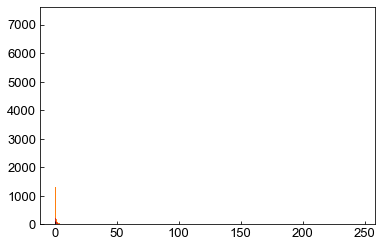

In [55]:
# statistic of nonaffine
steps_ = len(list_filename_)
centers_ = []
probability_density_ = []
for i_ in range(steps_):
    #     import data
    nonaffine_ = np.load('nonaffine_displacement_data/nonaffine_from_%d_to_%d.npy' % \
            (index_former_[i_], index_later_[i_]))
    ParticleInfo_former_ = read_ParticleInfo('../particle_info/particle_info_%d.txt', index_former_[i_])
    c_former_ = ParticleInfo_former_[:,[1,2]] # the coordinate of former particles
    c_former_ = c_former_.astype('float64')
    print('\nRead coordinate done\n')
   # screen value to avoid BC
    c_screened_, v_screened_ = screen_grains_by_x(x_lol_, x_upl_, c_former_, nonaffine_)
    # remove extreme value of nonaffine
    cnew_, vnew_ = remove_extreme_value(c_screened_, v_screened_ / np.mean(v_screened_), thresh_, y_lol_, y_upl_)  
    # stastics the count in each bins
    n_,bins_, patches_ = plt.hist(vnew_, bins = 1000)
    # record n_ and center of bins
    t_ = np.zeros(len(n_))
    for i_ in range(len(n_)):
        t_[i_] = (bins_[i_] + bins_[i_ + 1]) / 2
    centers_.append(t_)
    probability_density_.append(n_ / (t_[1] - t_[0])/ np.sum(n_))

In [56]:
np.sum(n_)

9815.0

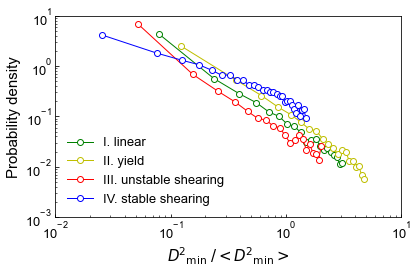

In [57]:
# define the exponential distribution function
def func(x_, lambda_, a0_):
    return  lambda_ * np.exp(-lambda_ * x_) 
plt.axes(yscale = "log", xscale = "log")
plt.rc('font', family = 'Arial')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


# popt0_, pcov0_ = curve_fit(func, centers_[0][0:20], probability_density_[0][0:20])
# plt.plot(centers_[0][0:20], func(centers_[0][0:20], *popt0_), linestyle = '--', color = 'g', label = 'I. linear, $\lambda$ = %.2f' % popt0_[0])

# popt1_, pcov1_ = curve_fit(func, centers_[1][0:20], probability_density_[1][0:20])
# plt.plot(centers_[1][0:20], func(centers_[1][0:20], *popt1_), linestyle = '--', color = 'y', label = 'II. yield, $\lambda$ = %.2f' % popt1_[0])

# popt2_, pcov2_ = curve_fit(func, centers_[2][0:20], probability_density_[2][0:20])
# plt.plot(centers_[2][0:20], func(centers_[2][0:20], *popt2_), linestyle = '--', color = 'r', label = 'III. unstable stick-slip, $\lambda$ = %.2f' % popt2_[0])

# popt3_, pcov3_ = curve_fit(func, centers_[3][0:20], probability_density_[3][0:20])
# plt.plot(centers_[3][0:20], func(centers_[3][0:20], *popt3_), linestyle = '--', color = 'b', label = 'IV. stable stick-slip, $\lambda$ = %.2f' % popt3_[0])


# plt.scatter(bins_large_[0:32], n_large_[0:32], c = 'none', edgecolor = 'r', linewidth = 1)
# plt.scatter(bins_small_[0:15], n_small_[0:15], c = 'none', edgecolor = 'k', linewidth = 1)
plt.plot(centers_[0][0:20], probability_density_[0][0:20], marker = 'o', markerfacecolor = 'w', color = 'g', linewidth = 1, label = 'I. linear')
plt.plot(centers_[1][0:20], probability_density_[1][0:20], marker = 'o', markerfacecolor = 'w', color = 'y', linewidth = 1, label = 'II. yield')
plt.plot(centers_[2][0:20], probability_density_[2][0:20], marker = 'o', markerfacecolor = 'w', color = 'r', linewidth = 1, label = 'III. unstable shearing')
plt.plot(centers_[3][0:30], probability_density_[3][0:30], marker = 'o', markerfacecolor = 'w', color = 'b', linewidth = 1, label = 'IV. stable shearing')
plt.ylim(10**-3, 10**1)
plt.xlim(10**-2, 10**1)
# plt.xlim(-0.005, 0.08)
plt.legend(frameon = False)

plt.xlabel('$\\mathit{D}$'+ '$^\\mathrm{2}$' + '$_\\mathrm{min}$' + ' $\\mathrm{/ <}$' + '$\\mathit{D}$'+ '$^\\mathrm{2}$' + '$_\\mathrm{min}$' + '$\\mathrm{>}$', fontsize=15)
plt.ylabel('Probability density', fontsize=15)



plt.tight_layout()
plt.savefig('note_book_plot/statistic nonaffine.svg', dpi=600, format='svg')
plt.show()

In [58]:
math.exp(2)

7.38905609893065